In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

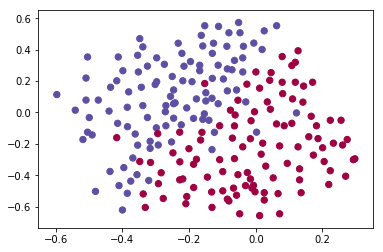

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## 1 - Non-regularized model


In [6]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):

    grads = {}
    costs = []                            
    m = X.shape[1]                        
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):

        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
      
        assert(lambd==0 or keep_prob==1)    
                                            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
     
        parameters = update_parameters(parameters, grads, learning_rate)
        

        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423284755


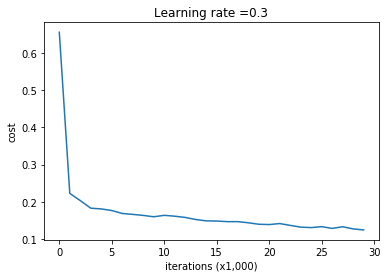

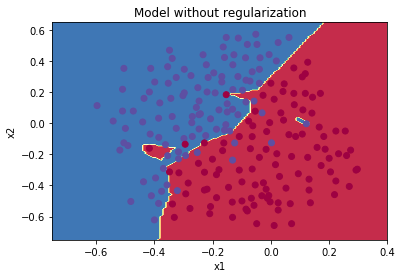

In [8]:
parameters = model(train_X, train_Y)
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## 2 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify your cost and observe the consequences.

**Exercise**: Implement `compute_cost_with_regularization()` which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , use :
```python
np.sum(np.square(Wl))
```
Note that you have to do this for $W^{[1]}$, $W^{[2]}$ and $W^{[3]}$, then sum the three terms and multiply by $ \frac{1}{m} \frac{\lambda}{2} $.

In [9]:

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) 
    
    L2_regularization_cost = lambd * ( np.sum( np.square(W1) ) + np.sum( np.square( W2 )) + np.sum( np.square(W3) ))/ (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [10]:
# A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

# print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

**Expected Output**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    
    </tr>

</table> 

Of course, because you changed the cost, you have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 

**Exercise**: Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [11]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + ( lambd * W3)/m 
    
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
   
    dW2 = 1./m * np.dot(dZ2, A1.T) + ( lambd * W2)/m
    
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1./m * np.dot(dZ1, X.T) + ( lambd * W1)/m
    
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.26849188732822393
Cost after iteration 20000: 0.2680916337127301


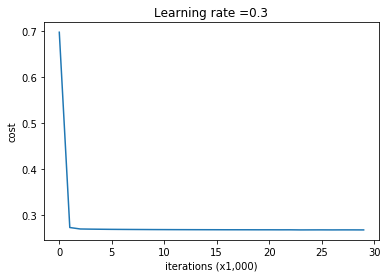

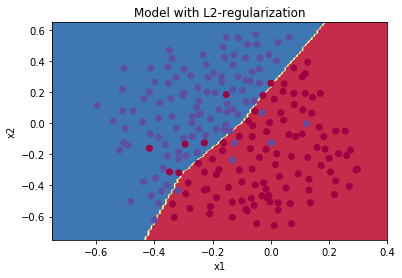

In [27]:
parameters = model(train_X, train_Y, lambd = 0.7)
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 3 Dropout

### 3.1 - Forward propagation with dropout

In [20]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    D1 = np.random.rand(A1.shape[0], A1.shape[1])       # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                                 # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                        # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.randn(A2.shape[0], A2.shape[1])          # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                                     # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                       # Step 3: shut down some neurons of A2
    A2 = A2/ keep_prob                                  # Step 4: scale the value of neurons that haven't been shut down
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [18]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.49683389 0.00305176 0.04565099 0.01446893 0.49683389]]


**Expected Output**: 

<table> 
    <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    
    </tr>

</table> 

### 3.2 - Backward propagation with dropout



In [21]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1    # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/ keep_prob             # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0: 0.6601172596517236
Cost after iteration 10000: 0.0802150483509354
Cost after iteration 20000: 0.07985093563163782


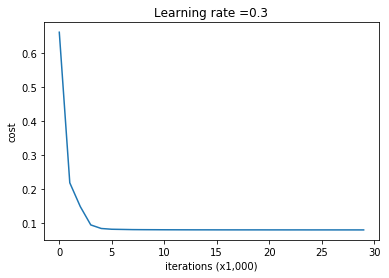

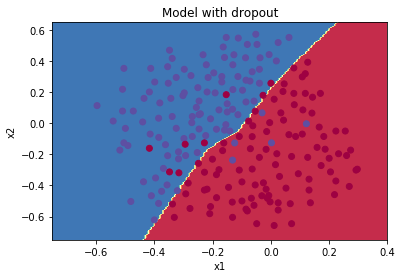

In [26]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)